In [223]:
import pandas as pd
data_combine = pd.read_excel('D:/大学/大三上/数据挖掘/作业/数据.xlsx')

In [224]:
data_combine = data_combine.drop(['text','word_split'],axis=1)

In [225]:
data_combine.isnull().sum()

author                  8392
id                         0
text_len                   0
symbol_num                 0
symbol_num_,               0
symbol_num_.               0
symbol_num_?               0
symbol_num_:               0
symbol_num_'               0
stopword_num               0
word_mean_length           0
char_num                   0
unique_word                0
svd_word_1to4gram_0        0
svd_word_1to4gram_1        0
svd_word_1to4gram_2        0
svd_word_1to4gram_3        0
svd_word_1to4gram_4        0
svd_word_1to4gram_5        0
svd_word_1to4gram_6        0
svd_word_1to4gram_7        0
svd_word_1to4gram_8        0
svd_word_1to4gram_9        0
svd_word_1to4gram_10       0
svd_word_1to4gram_11       0
svd_word_1to4gram_12       0
svd_word_1to4gram_13       0
svd_word_1to4gram_14       0
svd_word_1to4gram_15       0
svd_word_1to4gram_16       0
                        ... 
svd_char_1to5gram_22       0
svd_char_1to5gram_23       0
svd_char_1to5gram_24       0
sentence_senti

In [226]:
train_data = data_combine[:-8392]

In [227]:
test_data = data_combine[-8392:]

In [228]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_data['author'].map(author_mapping_dict)

In [229]:
train_data = train_data.drop(['author'],axis=1)

In [230]:
train_data = train_data.drop(['id'],axis=1)

In [128]:
from sklearn.preprocessing import minmax_scale

In [136]:
colum = list(data_combine.columns)

In [139]:
colum.remove('author')

In [140]:
colum.remove('id')

In [145]:
m =[minmax_scale(data_combine[i]) for i in colum]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


In [148]:
import numpy as np

In [151]:
train_x = pd.DataFrame(np.array(m).T)

In [232]:
import xgboost as xgb

In [234]:
xgb_matrix = xgb.DMatrix(train_data,train_y)

In [235]:
xgb_matrix

In [238]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 3
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.3
param['seed'] = 0
num_rounds = 3000
model = xgb.train(params=list(param.items()),dtrain=xgb_matrix,num_boost_round=num_rounds)

In [240]:
test_data = test_data.drop(['author','id'],axis=1)

In [241]:
test_y = model.predict(xgb.DMatrix(test_data))

In [242]:
test_y

array([[  3.38431739e-04,   2.12752799e-04,   9.99448836e-01],
       [  9.98437703e-01,   1.46341883e-03,   9.89359978e-05],
       [  4.69574079e-05,   9.99798715e-01,   1.54377631e-04],
       ..., 
       [  9.76716399e-01,   8.75667762e-03,   1.45268720e-02],
       [  8.45683087e-03,   1.04569081e-04,   9.91438627e-01],
       [  2.83275768e-02,   9.71666634e-01,   5.72910767e-06]], dtype=float32)

In [243]:
result = pd.DataFrame(test_y)

In [245]:
result_id = data_combine[-8392:].id

In [247]:
result_id = result_id.reset_index().drop('index',axis=1)

In [248]:
final_result = pd.concat([result_id,result],axis=1)

In [249]:
final_result.to_csv('d:/test.csv',index=False)

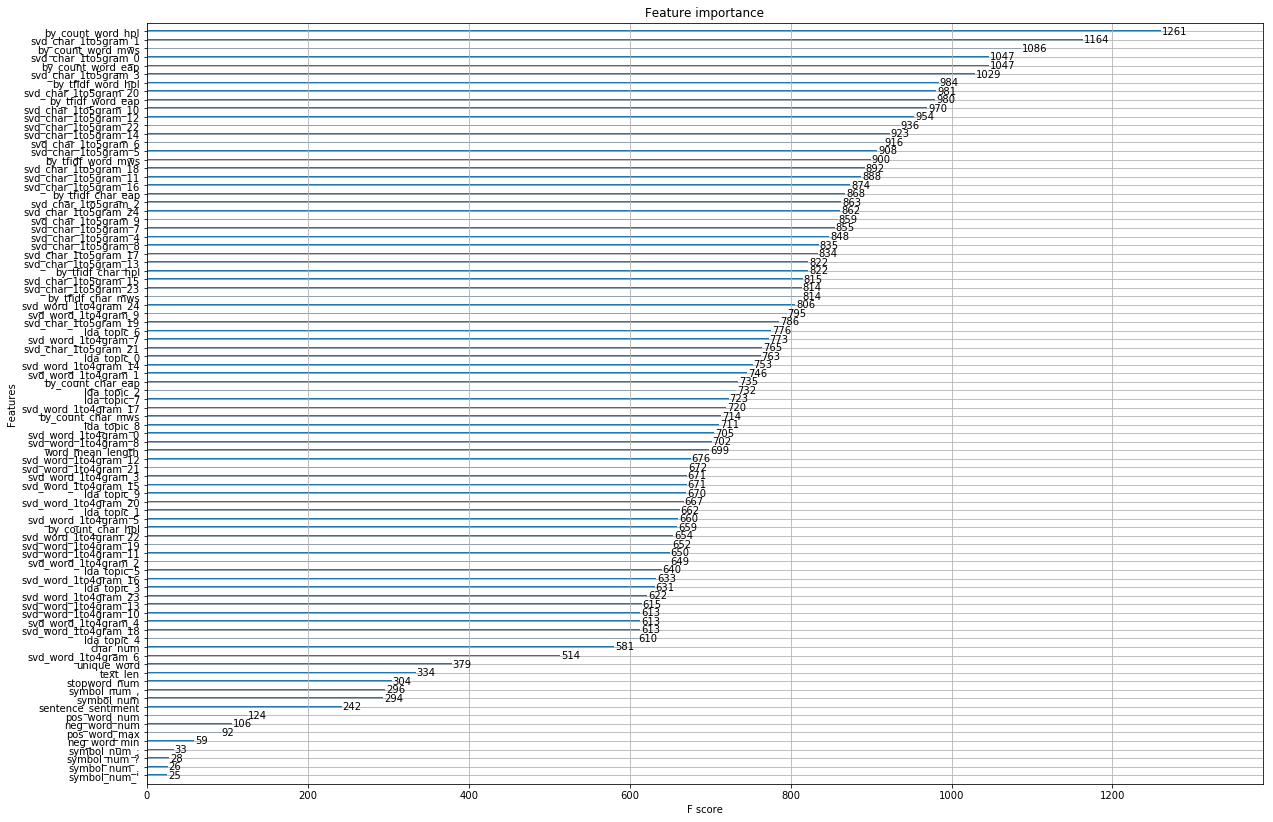

In [250]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(20,14))
ax = f.add_subplot(111)
xgb.plot_importance(model,ax=ax)
plt.show()

In [221]:
from sklearn.model_selection import KFold

In [222]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model